In [1]:
import os
import sys
import tempfile
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pymatch.Matcher import Matcher

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [2]:
def save_ids(ids, path_out, case,fold=None):
    tag = f'{case}.txt' if fold is None else f'{case}_test_set_{fold}.txt'
    filename = os.path.join(path_out,tag)
    with open(filename, 'w') as file:
        for i in ids:
            file.write(f"{i}\n")

In [3]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [4]:
def gen_split(dcase,dcon,yvar,test_size=0.25,seed=123):
    np.random.seed(seed)

    n_sub_test = int(dcase.shape[0]*test_size)

    case_select = np.random.choice(dcase.index,n_sub_test,replace=False)

    m = Matcher(dcase[dcase.index.isin(case_select)],dcon,yvar=yvar)

    m.fit_scores(balance=True, nmodels=100)
    m.predict_scores()
    m.match(method="min", nmatches=1, threshold=0.0009,with_replacement=False)
    return m.matched_data

In [10]:
import warnings
warnings.filterwarnings("ignore")

def gen_unique_splits(dcase,dcon,df,yvar,test_size=0.25,min_folds=5,max_fail=100,max_acc=0.55,min_acc=0.45,min_test_size=0.15):
    clf = SVC(C=100,class_weight='balanced')

    accuracy = []
    subsets = []
    seeds = []
    test_sizes = []
    fail_attempts = 0
    while (len(subsets) != min_folds) and (fail_attempts < max_fail):
        seed = np.random.randint(1e5)
        try:
            with HiddenPrints():
                matches = gen_split(dcase,dcon,yvar,test_size=test_size,seed=seed)
            split_test_size = matches.shape[0]/df.shape[0]

            X = pd.get_dummies(df[conf],['SEX','SITE'])
            y = df[case]

            X_train = X[~X.index.isin(matches['og_idx'])]
            X_test = X[X.index.isin(matches['og_idx'])]
            y_train = y[~y.index.isin(matches['og_idx'])]
            y_test = y[y.index.isin(matches['og_idx'])]

            clf.fit(X_train,y_train)
            pred = clf.predict(X_test)
            acc = accuracy_score(y_test,pred)
            
            fold_ids = matches['og_idx'].to_list()
            if (min_acc < acc < max_acc) & (split_test_size > min_test_size):
                if len(subsets) == 0:
                    subsets.append(fold_ids)
                    accuracy.append(acc)
                    seeds.append(seed)
                    test_sizes.append(split_test_size)
                    print(f'Subsets: {len(subsets)}')
                # Otherwise check if duplcate with existing selections
                else:
                    duplicate = []
                    for subset in subsets:
                        diff = set(subset).difference(set(fold_ids))
                        duplicate.append(len(diff) == 0)
                        
                    if not np.any(duplicate):
                        subsets.append(fold_ids)
                        accuracy.append(acc)
                        seeds.append(seed)
                        test_sizes.append(split_test_size)
                        print(f'Subsets: {len(subsets)}')

                    else:
                        fail_attempts += 1
                        if fail_attempts % 10 == 0: print(f'Fail: {fail_attempts}')
            else:
                fail_attempts += 1
                if fail_attempts % 10 == 0: print(f'Fail: {fail_attempts}')

        except:
            fail_attempts += 1
            if fail_attempts % 10 == 0: print(f'Fail: {fail_attempts}')
            
    return subsets, seeds, accuracy, test_sizes

## Load data

In [6]:
p_pheno = '/home/harveyaa/Documents/fMRI/data/ukbb_9cohorts/pheno_26-01-22.csv'
p_ids = '/home/harveyaa/Documents/masters/MTL/conf_balancing/mleming/dataset_ids'
p_out = '/home/harveyaa/Documents/masters/MTL/conf_balancing/pymatch/dataset_ids'

pheno = pd.read_csv(p_pheno,index_col=0)

In [7]:
cases = [#'SZ',
        #'ASD',
        #'BIP',
        #'DEL22q11_2', #FAIL
        'DUP22q11_2', #GOOD
        #'DEL16p11_2', #GOOD
        #'DUP16p11_2', #FAIL
        #'DEL1q21_1', #GOOD
        #'DUP1q21_1' #GOOD
        ]

## Load datasets

In [8]:
sel_ids = []
for case in cases:
    df = pd.read_csv(os.path.join(p_ids,f"{case}.txt"),header=None)
    sel_ids.append(df)
sel_ids = dict(zip(cases,sel_ids))

## Generate splits

In [9]:
all_selections = {}
all_seeds = {}
all_accuracy = {}
all_test_sizes = {}
for case in cases:
    print(case)
    control = 'CON_IPC' if case in ['SZ','ASD','BIP'] else 'non_carriers'
    conf = ['AGE','SEX','SITE','mean_conn','FD_scrubbed'] if case != 'DEL22q11_2' else ['AGE','SEX','mean_conn','FD_scrubbed']

    p = pheno[pheno.index.isin(sel_ids[case][0].to_list())]
    df_con = p[(p[control] == 1)&(p['PI'].isin(p[p[case] == 1]['PI'].unique()))][conf + [case]]
    df_case = p[p[case]==1][conf + [case]]

    df_con.loc[:,case] = df_con.loc[:,case].astype(int)
    df_case.loc[:,case] = df_case.loc[:,case].astype(int)

    selections,seeds,accuracy,test_sizes = gen_unique_splits(df_case,df_con,p,case,
                            test_size=0.3,
                            min_folds=5,
                            max_fail=300,
                            max_acc=0.55,
                            min_acc=0.45,
                            min_test_size=0.1)
    print(len(selections))
    print(accuracy)
    all_selections[case] = selections
    all_seeds[case] = seeds
    all_accuracy[case] = accuracy
    all_test_sizes[case] = test_sizes

DUP22q11_2
Subsets: 1
Subsets: 2
Fail: 10
Subsets: 3
Fail: 20
Subsets: 4
Fail: 30
Subsets: 5
5
[0.5, 0.5, 0.5, 0.5]


In [11]:
temp_dir = tempfile.mkdtemp()

for case in all_selections:
    print(case)
    print("subsets: ", len(all_selections[case]))
    print("mean test size: ", np.mean(all_test_sizes[case]))
    print("mean accuracy: ", np.mean(all_accuracy[case]))
    print()

    if len(all_selections[case]) == 5:
        print(f"Saving {case}...")
        for i,ids in enumerate(all_selections[case]):
            save_ids(ids,temp_dir,case,i)

tag = '{}.txt'
tag_split = '{}_test_set_{}.txt'

for case in all_selections:
    dataset_ids = pd.read_csv(os.path.join(p_ids,tag.format(case)),header=None)
    dataset_ids.set_index(0,inplace=True)

    for i in range(5):
        p_split_ids = os.path.join(temp_dir,tag_split.format(case,i))
        if os.path.exists(p_split_ids):
            s_ids = pd.read_csv(p_split_ids,header=None)
            dataset_ids[f'fold_{i}'] = 1*dataset_ids.index.isin(s_ids[0].to_list())

    dataset_ids[case] = pheno[pheno.index.isin(dataset_ids.index)][case].values.astype(int)

    if 'fold_4' in dataset_ids.columns:
        dataset_ids.to_csv(os.path.join(p_out,f"{case}.csv"))


DUP22q11_2
subsets:  5
mean test size:  0.1590909090909091
mean accuracy:  0.5

Saving DUP22q11_2...


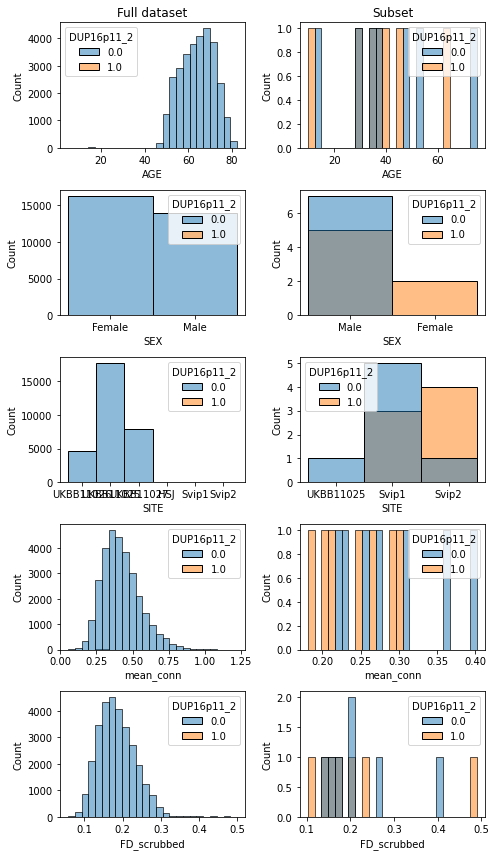

In [40]:
ids = selections[1]
        

sites = pheno[pheno[case]==1]['SITE'].unique()
df = pheno[(pheno['SITE'].isin(sites))
        & ((pheno[case]==1)|(pheno[control]==1))]

fig, ax = plt.subplots(len(conf),2,figsize=(7,12))
for i,c in enumerate(conf):
        sns.histplot(x=c,data=df,hue=case,bins=25,ax=ax[i,0])
        
        sns.histplot(x=c,data=df[df.index.isin(ids)],hue=case,bins=25,ax=ax[i,1])
        if i == 0:
                ax[i,0].set_title('Full dataset')
                ax[i,1].set_title('Subset')
plt.tight_layout()